In [1]:
# disable INFO msgs in gensim
import logging
import warnings
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import numpy as np
import pandas as pd
import re
import os
import time
import pickle
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML

# for training and prediction
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# for calculating similarities among text
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models, similarities

In [2]:
# Functions for save and load derived data objects
def save_obj(obj, fpath):
    with open(fpath, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(fpath):
    if os.path.exists(fpath):
        with open(fpath, 'rb') as f:
            return pickle.load(f)
    else:
        return None

## Check the path of your csv files before loading the data

In [3]:
col_types = {'Id': 'int', 
             'OwnerUserId': 'float', 
             'CreationDate': 'str', 
             'ParentId': 'int', 
             'Score': 'int',
             'Title': 'str',
             'Body':'str'}

questions = pd.read_csv('/pythonquestions/Questions.csv', encoding = "ISO-8859-1", dtype=col_types)
answers = pd.read_csv('/pythonquestions/Answers.csv', encoding = "ISO-8859-1", dtype=col_types)

In [4]:
# question to answer: (ans_id, score, owner_id)
q_to_a = load_obj('checkpoint/q_to_a.pkl')
if not q_to_a:
    q_to_a = dict()
    for _, row in answers[['Id', 'ParentId', 'Score', 'OwnerUserId']].iterrows():
        q_id = row['ParentId']
        a_id = row['Id']
        a_score = row['Score']
        a_owner_id = row['OwnerUserId'] if not np.isnan(row['OwnerUserId']) else None
        if q_id not in q_to_a:
            q_to_a[q_id] = [(a_id, a_score, a_owner_id)]
        else:
            q_to_a[q_id].append((a_id, a_score, a_owner_id))
            
    save_obj(q_to_a, 'checkpoint/q_to_a.pkl')

# Keep only the questions with 4-10 answers and a distinguishable answer
q_to_a = {k:v for k, v in q_to_a.items() if len(v)>3 and len(v)<11 and max(v, key=lambda x: x[1])[1]>0}
    
# keep only qualified questions
questions = questions[questions['Id'].isin(q_to_a)]

In [5]:
# Keep only answers related to a qualified question
def answer_in_use(answer):
    if answer['ParentId'] in q_to_a:
        for item in q_to_a[answer['ParentId']]:
            if answer['Id'] == item[0]:
                return True
    return False

answers = answers[answers.apply(lambda x: answer_in_use(x), axis=1)]

In [6]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44184 entries, 0 to 607160
Data columns (total 6 columns):
Id              44184 non-null int32
OwnerUserId     43286 non-null float64
CreationDate    44184 non-null object
Score           44184 non-null int32
Title           44184 non-null object
Body            44184 non-null object
dtypes: float64(1), int32(2), object(3)
memory usage: 2.0+ MB


In [7]:
answers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215203 entries, 0 to 987106
Data columns (total 6 columns):
Id              215203 non-null int32
OwnerUserId     213419 non-null float64
CreationDate    215203 non-null object
ParentId        215203 non-null int32
Score           215203 non-null int32
Body            215203 non-null object
dtypes: float64(1), int32(3), object(2)
memory usage: 9.0+ MB


## Semantic features: Question-Ans similarity and Ans-Ans similarity
### (It took 1.5 hr to run on my Core-i7-7700 / 32GB RAM laptop)

In [8]:
#t_start = time.time()

In [9]:
def compute_sim(q_to_a, df_questions, df_answers):
    a_sim = dict()
    tokenizer = RegexpTokenizer(r'\w+')
    print(len(q_to_a))
    c = 0
    for q_id, a_list in q_to_a.items():
        
        c+=1
        print(str(c) + ' ' + str(len(a_list)), end='\r')
        
        # get split body text for a question and the answers
        q_body = df_questions[df_questions['Id']==q_id].iloc[0]['Body']
        q_body = BeautifulSoup(q_body, 'html.parser').get_text()#.split()
        q_body = tokenizer.tokenize(q_body.lower())
        q_body = [w for w in q_body if w not in stopwords.words('english')]
        #print(q_body)
        
        a_bodies = list()
        for a_id, _, _ in a_list:
            a_body = df_answers[df_answers['Id']==a_id].iloc[0]['Body']
            a_body = BeautifulSoup(a_body, 'html.parser').get_text()#.split()
            a_body = tokenizer.tokenize(a_body.lower())
            a_body = [w for w in a_body if w not in stopwords.words('english')]
            a_bodies.append(a_body)
        #print(a_bodies)
        
        # apply a series of transformations to the answers: bag-of-word, tf-idf, and lsi
        dictionary = corpora.Dictionary(a_bodies)
        corpus = [dictionary.doc2bow(a) for a in a_bodies]
        #print(a_bodies[0], len(a_bodies[0]))
        #print(corpus[0], len(corpus[0]))
        tfidf = models.TfidfModel(corpus)
        corpus_tfidf = tfidf[corpus]
        #print(corpus_tfidf[0], len(corpus_tfidf[0]))
        lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=4)
        corpus_lsi = lsi[corpus_tfidf]
        #print(corpus_lsi[0], len(corpus_lsi[0]))
        
        index = similarities.MatrixSimilarity(corpus_lsi)
        
        # question-to-answer similarity
        q_bow = dictionary.doc2bow(q_body)
        q_lsi = lsi[q_bow]
        q_to_a_sim = index[q_lsi]
        #print(q_to_a_sim)
        
        # ans-to-ans similarity, excluding the answer itself
        for idx, a_lsi in enumerate(corpus_lsi):
            a_to_a_sim = index[a_lsi]
            a_to_a_sim = [a_to_a_sim[i] for i in range(len(a_to_a_sim)) if i != idx]  # exclude itself
            
            # construct the dictionary a_sim
            a_id = a_list[idx][0]
            sim_to_q = q_to_a_sim[idx]
            max_sim_to_a = max(a_to_a_sim)
            min_sim_to_a = min(a_to_a_sim)
            a_sim[a_id] = (sim_to_q, max_sim_to_a, min_sim_to_a)
    
    return a_sim

# a_sim: a_id -> (sim_to_question, max_sim_to_other_ans, min_sim_to_other_ans)
a_sim = load_obj('checkpoint/a_sim.pkl')
if not a_sim:
    a_sim = compute_sim(q_to_a, questions, answers)
    save_obj(a_sim, 'checkpoint/a_sim.pkl')

In [10]:
#t_end = time.time()
#print('time elapsed: %f minutes', ((t_end-t_start)/60.0))

In [11]:
answers = answers.assign(SimToQ = answers['Id'].apply(lambda a_id: a_sim[a_id][0]))
answers = answers.assign(MaxSimToA = answers['Id'].apply(lambda a_id: a_sim[a_id][1]))
answers = answers.assign(MinSimToA = answers['Id'].apply(lambda a_id: a_sim[a_id][2]))
answers.head(3)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,SimToQ,MaxSimToA,MinSimToA
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,0.463144,0.010914,0.000000
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,0.616794,0.144977,0.000000
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,0.088449,0.853997,-0.253043


## Shallow Features

In [12]:
def strip_code(html):
    bs = BeautifulSoup(html, 'html.parser')
    [s.extract() for s in bs('code')]
    return bs.get_text()

answers = answers.assign(BodyEnglishText = answers['Body'].apply(strip_code))
answers = answers.assign(EnglishCount = answers['BodyEnglishText'].apply(lambda x: len(x.split())))
answers.head(3)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,SimToQ,MaxSimToA,MinSimToA,BodyEnglishText,EnglishCount
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,0.463144,0.010914,0.000000,open up a terminal (Applications->Utilities->T...,29
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,0.616794,0.144977,0.000000,I haven't been able to find anything that does...,38
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,0.088449,0.853997,-0.253043,One possibility is Hudson. It's written in Ja...,36


In [13]:
def count_links(html):
    bs = BeautifulSoup(html, 'html.parser')
    return len(bs.find_all('a'))

answers = answers.assign(LinkCount = answers['Body'].apply(count_links))
answers.head(3)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,SimToQ,MaxSimToA,MinSimToA,BodyEnglishText,EnglishCount,LinkCount
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,0.463144,0.010914,0.000000,open up a terminal (Applications->Utilities->T...,29,0
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,0.616794,0.144977,0.000000,I haven't been able to find anything that does...,38,0
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,0.088449,0.853997,-0.253043,One possibility is Hudson. It's written in Ja...,36,2


In [14]:
def has_code(html):
    bs = BeautifulSoup(html, 'html.parser')
    return 1 if bs.find('code') else 0

answers = answers.assign(HasCode = answers['Body'].apply(has_code))
answers.head(3)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,SimToQ,MaxSimToA,MinSimToA,BodyEnglishText,EnglishCount,LinkCount,HasCode
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,0.463144,0.010914,0.000000,open up a terminal (Applications->Utilities->T...,29,0,1
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,0.616794,0.144977,0.000000,I haven't been able to find anything that does...,38,0,1
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,0.088449,0.853997,-0.253043,One possibility is Hudson. It's written in Ja...,36,2,0


In [15]:
def code_length(html):
    bs = BeautifulSoup(html, 'html.parser')
    contents = [tag.text.split() for tag in bs.find_all('code')]
    return sum(len(item) for item in contents)

answers = answers.assign(CodeLength = answers['Body'].apply(code_length))
answers = answers.assign(TotalLength = answers.apply(lambda row: row['EnglishCount'] + row['CodeLength'], axis=1))
answers.head(3)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,SimToQ,MaxSimToA,MinSimToA,BodyEnglishText,EnglishCount,LinkCount,HasCode,CodeLength,TotalLength
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,0.463144,0.010914,0.000000,open up a terminal (Applications->Utilities->T...,29,0,1,2,31
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,0.616794,0.144977,0.000000,I haven't been able to find anything that does...,38,0,1,3,41
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,0.088449,0.853997,-0.253043,One possibility is Hudson. It's written in Ja...,36,2,0,0,36


In [16]:
def get_order(qid, aid):
    ids = [i[0] for i in q_to_a[qid]]
    return ids.index(aid)+1

answers = answers.assign(PostOrder = answers.apply(lambda row: get_order(row['ParentId'], row['Id']), axis=1))
answers.head(3)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,SimToQ,MaxSimToA,MinSimToA,BodyEnglishText,EnglishCount,LinkCount,HasCode,CodeLength,TotalLength,PostOrder
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,0.463144,0.010914,0.000000,open up a terminal (Applications->Utilities->T...,29,0,1,2,31,1
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,0.616794,0.144977,0.000000,I haven't been able to find anything that does...,38,0,1,3,41,2
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,0.088449,0.853997,-0.253043,One possibility is Hudson. It's written in Ja...,36,2,0,0,36,1


In [17]:
def is_answer(qid, aid):
    if aid == max(q_to_a[qid], key=lambda item: item[1])[0]:
        return 1
    else:
        return 0
    
answers = answers.assign(IsAnswer = answers.apply(lambda row: is_answer(row['ParentId'], row['Id']), axis=1))
answers.head(3)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,SimToQ,MaxSimToA,MinSimToA,BodyEnglishText,EnglishCount,LinkCount,HasCode,CodeLength,TotalLength,PostOrder,IsAnswer
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,0.463144,0.010914,0.000000,open up a terminal (Applications->Utilities->T...,29,0,1,2,31,1,0
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,0.616794,0.144977,0.000000,I haven't been able to find anything that does...,38,0,1,3,41,2,0
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,0.088449,0.853997,-0.253043,One possibility is Hudson. It's written in Ja...,36,2,0,0,36,1,1


In [18]:
# calculate reputation scores for users
user_rep = dict()
for ans_list in q_to_a.values():
    for _, score, owner_id in ans_list:
        if owner_id:
            if owner_id in user_rep:
                user_rep[owner_id] += score
            else:
                user_rep[owner_id] = score

In [19]:
def get_reputation(userId):
    if not np.isnan(userId) and userId in user_rep:
        return user_rep[userId]
    else:
        return 0

answers = answers.assign(Reputation = answers['OwnerUserId'].apply(get_reputation))
answers.head(3)

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,SimToQ,MaxSimToA,MinSimToA,BodyEnglishText,EnglishCount,LinkCount,HasCode,CodeLength,TotalLength,PostOrder,IsAnswer,Reputation
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,0.463144,0.010914,0.000000,open up a terminal (Applications->Utilities->T...,29,0,1,2,31,1,0,5.0
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,0.616794,0.144977,0.000000,I haven't been able to find anything that does...,38,0,1,3,41,2,0,2.0
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,0.088449,0.853997,-0.253043,One possibility is Hudson. It's written in Ja...,36,2,0,0,36,1,1,30.0


## Training: RandomForest

In [20]:
q_train, q_validation = model_selection.train_test_split(questions, test_size=0.2, random_state=42)

In [21]:
a_train = answers[answers['ParentId'].isin(q_train['Id'])]
a_validation = answers[answers['ParentId'].isin(q_validation['Id'])]

In [22]:
x_train = a_train[['TotalLength','LinkCount', 'CodeLength', 'PostOrder', 'Reputation', 'SimToQ', 'MaxSimToA', 'MinSimToA']]
y_train = a_train[['IsAnswer']]
x_val = a_validation[['Id', 'TotalLength','LinkCount', 'CodeLength', 'PostOrder', 'Reputation', 'SimToQ', 'MaxSimToA', 'MinSimToA']]
y_val = a_validation[['IsAnswer']]

In [23]:
rf_classifier = RandomForestClassifier(
    n_estimators=1000, min_samples_leaf=4, n_jobs=-1, oob_score=True, random_state=42)

rf_classifier.fit(x_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [24]:
y_pred = rf_classifier.predict_proba(x_val.iloc[:, 1:])

In [25]:
def get_accuracy(q_ids, a_ids, prob_pred):
    a_to_prob = dict()
    for idx, a_id in enumerate(a_ids):
        prob = prob_pred[:, 1][idx]
        a_to_prob[a_id] = prob
        
    count = 0
    for q_id in q_ids:
        right_answer = max(q_to_a[q_id], key=lambda item: item[1])[0]
        predict_answer = 0
        highest_score = 0
        for a_id, score, _ in q_to_a[q_id]:
            pred_score = a_to_prob[a_id]
            if pred_score > highest_score:
                predict_answer = a_id
                highest_score = pred_score
        if right_answer==predict_answer:
            count += 1
    return count/len(q_ids)

print('RF model accuracy:', get_accuracy(q_validation['Id'].tolist(), a_validation['Id'].tolist(), y_pred))

RF model accuracy: 0.4722190788729207


# Baseline

In [26]:
def baseline(q_ids, a_val):
    count_first = 0
    count_last = 0
    count_long = 0
    for q_id in q_ids:
        right_answer = max(q_to_a[q_id], key=lambda item: item[1])[0]
        
        first_answer = q_to_a[q_id][0][0]
        if right_answer==first_answer:
            count_first += 1
        
        last_answer = q_to_a[q_id][-1][0]
        if right_answer==last_answer:
            count_last += 1
            
        longest_answer = -1
        max_length = 0
        for a_id, score, _ in q_to_a[q_id]:
            leng = a_val[a_val.Id==a_id].iloc[0]['TotalLength']
            if leng > max_length:
                longest_answer = a_id
                max_length = leng
        if right_answer==longest_answer:
            count_long += 1
    print('Baseline for the first answer:', count_first/len(q_ids))
    print('Baseline for the last answer:', count_last/len(q_ids))
    print('Baseline for the longest answer:', count_long/len(q_ids))

baseline(q_validation['Id'].tolist(), a_validation)

Baseline for the first answer: 0.3969672965938667
Baseline for the last answer: 0.07649654860246691
Baseline for the longest answer: 0.29885707819395724


# Explaintion of important features

In [27]:
x_val = x_val.assign(PredictProba = y_pred[:, 1])

In [28]:
x_val.head(10)

,Id,TotalLength,LinkCount,CodeLength,PostOrder,Reputation,SimToQ,MaxSimToA,MinSimToA,PredictProba
3,538,36,2,0,1,30.0,0.088449,0.853997,-0.253043,0.266744
4,541,42,1,0,2,25.0,0.311929,0.870562,-0.253043,0.185931
6,660,144,1,0,3,14.0,0.715509,0.870562,-0.024699,0.239758
12,777,69,1,21,1,18.0,0.402861,0.898897,-0.058123,0.341554
14,802,89,1,15,2,2.0,0.029272,0.242804,-0.186001,0.159389
20,1619,93,0,0,3,26.0,0.441102,0.898897,-0.186001,0.160125
21,1780,60,1,0,1,10.0,0.637466,0.028481,0.001687,0.309161
52,5302,31,0,0,1,8.0,0.676577,0.048136,0.022835,0.448748
66,6161,44,1,0,2,10.0,0.301457,0.040292,0.028481,0.234697
78,8332,58,2,0,4,1249.0,0.875642,0.956945,-0.078915,0.226228


In [29]:
importances = rf_classifier.feature_importances_

In [30]:
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_val.shape[1]-2):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 4 (0.195030)
2. feature 3 (0.136927)
3. feature 5 (0.136447)
4. feature 6 (0.135448)
5. feature 7 (0.134970)
6. feature 0 (0.130650)
7. feature 2 (0.106142)
8. feature 1 (0.024386)


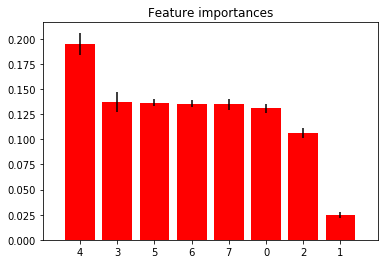

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Feature importances")
plt.bar(range(x_val.shape[1]-2), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_val.shape[1]-2), indices)
plt.xlim([-1, x_val.shape[1]-2])
plt.show()